In [1]:
import numpy as np
import pandas as pd
import datetime as dt
from scipy import stats
import plotly.express as px
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import json
import ast
import os
import re

import sklearn
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from yellowbrick.target import FeatureCorrelation
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, RobustScaler, StandardScaler
from collections import Counter
from sklearn.pipeline import Pipeline

# The following lines adjust the granularity of reporting. 
# pd.options.display.max_rows = 16
pd.set_option('display.max_columns', None)
# pd.options.display.float_format = "{:.1f}".format

In [2]:
df = pd.read_csv('user_songs_filtered.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173599 entries, 0 to 173598
Data columns (total 27 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Username           173599 non-null  object 
 1   country            173599 non-null  object 
 2   registered_year    173599 non-null  int64  
 3   track_count        173599 non-null  int64  
 4   artist_count       173599 non-null  int64  
 5   track_name         173599 non-null  object 
 6   artist_name        173599 non-null  object 
 7   rank               173599 non-null  int64  
 8   playcount          173599 non-null  int64  
 9   lyrics             173599 non-null  object 
 10  duration_ms        173599 non-null  float64
 11  listeners          173599 non-null  float64
 12  total_playcount    173599 non-null  float64
 13  toptags            173599 non-null  object 
 14  profanity_density  173599 non-null  float64
 15  polarity           173599 non-null  float64
 16  su

In [4]:
pd.set_option('display.max_columns', None)
df.head()

,Username,country,registered_year,track_count,artist_count,track_name,artist_name,rank,playcount,lyrics,duration_ms,listeners,total_playcount,toptags,profanity_density,polarity,subjectivity,emotion1,emotion1_score,emotion2,emotion2_score,mfcc,chroma,rms,spectral_centroid,zcr,tempo
0,emosoup,United States,2015,13520,3386,The Love You Want,Sleep Token,2,1205,you lie an inch apart on your own continuum\nn...,263000.0,50648.0,742132.0,"['DJENT', 'Progressive metal', 'alt-pop', 'art...",0.0,0.31429,0.62517,positive,0.334746,joy,0.173734,[-149.40892 203.93697 -22.01892 5.7...,[0.45397684 0.2743586 0.31350356 0.21251707 0...,0.205037,1595.110449,0.041794,132.512019
1,Katiefayce,Unknown,2010,5020,1568,The Love You Want,Sleep Token,31,84,you lie an inch apart on your own continuum\nn...,263000.0,50648.0,742132.0,"['DJENT', 'Progressive metal', 'alt-pop', 'art...",0.0,0.31429,0.62517,positive,0.334746,joy,0.173734,[-149.40892 203.93697 -22.01892 5.7...,[0.45397684 0.2743586 0.31350356 0.21251707 0...,0.205037,1595.110449,0.041794,132.512019
2,maiconslavieiro,Brazil,2019,18795,6513,The Love You Want,Sleep Token,8,193,you lie an inch apart on your own continuum\nn...,263000.0,50648.0,742132.0,"['DJENT', 'Progressive metal', 'alt-pop', 'art...",0.0,0.31429,0.62517,positive,0.334746,joy,0.173734,[-149.40892 203.93697 -22.01892 5.7...,[0.45397684 0.2743586 0.31350356 0.21251707 0...,0.205037,1595.110449,0.041794,132.512019
3,velenious,United States,2013,32367,8810,The Love You Want,Sleep Token,11,1393,you lie an inch apart on your own continuum\nn...,263000.0,50648.0,742132.0,"['DJENT', 'Progressive metal', 'alt-pop', 'art...",0.0,0.31429,0.62517,positive,0.334746,joy,0.173734,[-149.40892 203.93697 -22.01892 5.7...,[0.45397684 0.2743586 0.31350356 0.21251707 0...,0.205037,1595.110449,0.041794,132.512019
4,Jakesibley00,Unknown,2022,4642,944,The Love You Want,Sleep Token,20,155,you lie an inch apart on your own continuum\nn...,263000.0,50648.0,742132.0,"['DJENT', 'Progressive metal', 'alt-pop', 'art...",0.0,0.31429,0.62517,positive,0.334746,joy,0.173734,[-149.40892 203.93697 -22.01892 5.7...,[0.45397684 0.2743586 0.31350356 0.21251707 0...,0.205037,1595.110449,0.041794,132.512019


In [5]:
df.nunique()

Username              5647
country                127
registered_year         23
track_count           5244
artist_count          3889
track_name           54297
artist_name          15987
rank                    50
playcount             2405
lyrics               59350
duration_ms            881
listeners            48353
total_playcount      58401
toptags              41130
profanity_density     6445
polarity             29582
subjectivity         26008
emotion1                 9
emotion1_score       62551
emotion2                 9
emotion2_score       62551
mfcc                 49299
chroma               49299
rms                  49202
spectral_centroid    49299
zcr                  48195
tempo                  147
dtype: int64

## EDA

In [3]:
user_songs_filtered.describe().transpose()

,registered_year,track_count,artist_count,rank,playcount,duration_ms,listeners,total_playcount,profanity_density,polarity,subjectivity,emotion1_score,emotion2_score,rms,spectral_centroid,zcr,tempo
count,173599.000000,173599.000000,173599.000000,173599.000000,1.735990e+05,1.735990e+05,1.735990e+05,1.735990e+05,173599.000000,173599.000000,173599.000000,173599.000000,1.735990e+05,173599.000000,173599.000000,173599.000000,173599.000000
mean,2016.119379,20007.836854,3598.955962,25.174344,1.746437e+02,1.919761e+05,3.619358e+05,3.861728e+06,0.004287,0.040297,0.518155,0.147115,9.332364e-02,0.220126,2628.285048,0.056534,120.535614
std,5.430732,24663.969914,4955.741265,14.449092,2.632648e+03,1.370069e+05,4.444351e+05,6.044732e+06,0.012377,0.178027,0.142212,0.074655,4.439021e-02,0.079340,782.281067,0.022868,28.785019
min,2002.000000,0.000000,0.000000,1.000000,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,-1.000000,0.000000,0.000002,7.843739e-07,0.000000,0.000000,0.000000,0.000000
25%,2011.000000,5806.000000,1135.000000,13.000000,5.200000e+01,1.350000e+05,4.818850e+04,2.995340e+05,0.000000,-0.064790,0.437210,0.097799,6.314279e-02,0.164174,2100.223047,0.039308,99.384014
50%,2018.000000,12470.000000,2225.000000,25.000000,9.500000e+01,2.050000e+05,1.863700e+05,1.448009e+06,0.000000,0.035610,0.518560,0.134077,8.790143e-02,0.226257,2676.708374,0.055265,120.185320
75%,2021.000000,24803.000000,4284.000000,38.000000,1.690000e+02,2.570000e+05,5.200510e+05,4.997753e+06,0.002008,0.143330,0.600485,0.180869,1.161973e-01,0.275359,3178.215633,0.072208,139.674831
max,2024.000000,354860.000000,94818.000000,50.000000,1.043472e+06,1.080000e+07,3.115370e+06,1.476307e+08,0.383784,1.000000,1.000000,1.024073,6.030678e-01,0.749741,7824.394576,0.375930,303.998162


In [5]:
# Descriptive Statistics
numerical_cols = ['playcount',
                  'artist_count',
                  'track_count',
                  'album_count',
                  'registered_year',
                  ]

descriptive_stats = df[numerical_cols].describe().loc[['min', 'max', 'mean', 'std', '50%']].transpose()
descriptive_stats.columns = ['min', 'max', 'mean', 'std', 'median']
descriptive_stats['mode'] = df[numerical_cols].mode().transpose()[0]
descriptive_stats['mad'] = [stats.median_abs_deviation(df[x]) for x in numerical_cols]
descriptive_stats['kurtosis'] = [stats.kurtosis(df[x], fisher=False) for x in numerical_cols]
descriptive_stats['skewness'] = [stats.skew(df[x]) for x in numerical_cols]
descriptive_stats

,min,max,mean,std,median,mode,mad,kurtosis,skewness
playcount,0.0,8463249.0,113356.554123,166606.613800,74776.0,0,48280.0,673.882259,16.504432
artist_count,0.0,139439.0,3619.024188,5592.206766,2197.0,1,1342.0,138.921502,8.751268
track_count,0.0,427379.0,20748.606297,27427.188396,12703.0,1,8163.0,41.127629,4.764983
album_count,0.0,192746.0,6913.037581,9591.512136,4244.0,0,2654.0,71.076527,6.086159
registered_year,2002.0,2024.0,2015.903448,5.485402,2018.0,2021,4.0,1.891182,-0.456785


As we can observe from discriptive statistics, the various music playing counts of users are quite postively skewed. The positive skewness of music playing counts suggests that most users have relatively low playcounts, but there are a few users with extremely high playcounts, resulting in the right-skewed distribution.

Out of these, `playcount` and `album_count` have mode value of 0. This could mean that a significant number of users have not played any songs or albums, respectively. For example, it could be due to inactive accounts, new users who have not started using the platform yet. However, it could also be due to users who listen to music but do not scrobble their plays to Last.fm, since the users have non-empty `Top_50` songs lists. 

The users have a wide range of registration year from 2002 to 2024. Moving on, we plot histograms to visualize the distribution of these numerical columns. 

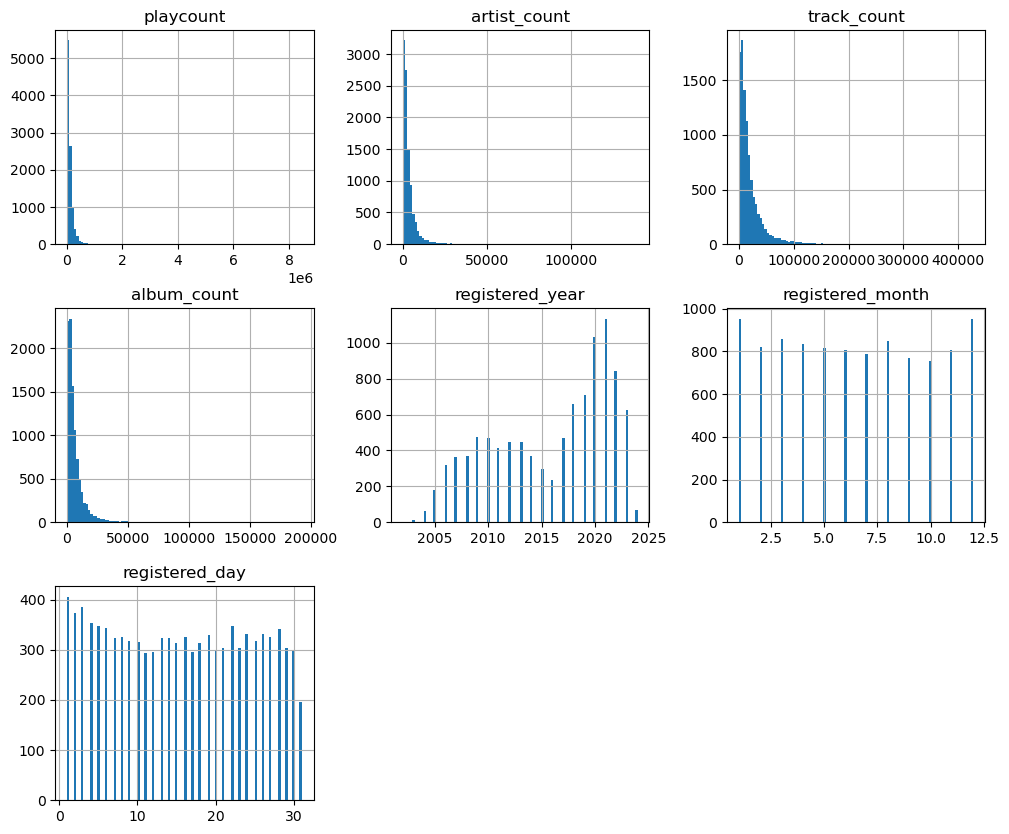

In [6]:
# histogram of features to observe the distribution of values
ax = df.hist(figsize = (12, 10), bins = 100)


# plt.clf()
# num_features = len(numerical_features)
# num_rows = min(num_features, 5) 
# num_cols = (num_features - 1) // num_rows + 1 
# plt.figure(figsize=(5 * num_cols, 5 * num_rows))
# for i, col in enumerate(numerical_features):
#     plt.subplot(num_rows, num_cols, i + 1)
#     sns.histplot(songs_all[col])
#     plt.title(col)
# plt.tight_layout()
# plt.show()

From the above analysis and visualization, we find `track_count` to be the most representative music playing counts among the four for users' activeness on the platform. There are extreme outliers in this value, therefore, we have decided to transform it into categorical variable, though risking losing some information. 

In [7]:
# transform track_count to categorical
categories = pd.cut(df.track_count, bins = [0, 4600, 9500, 16000, 30000, 450000],
                    labels = ["most inactive", "inactive", "medium", "active", "most active"])
categories.value_counts(normalize = True)
# TODO
# df['tempo_bin'] = pd.cut(df['tempo'], bins=[0, np.percentile(df['tempo'], 0.33), np.percentile(df['tempo'], 0.66), 220], labels=['slow', 'medium', 'fast'])

track_count
active           0.211142
inactive         0.203441
most active      0.199640
medium           0.194539
most inactive    0.191238
Name: proportion, dtype: float64

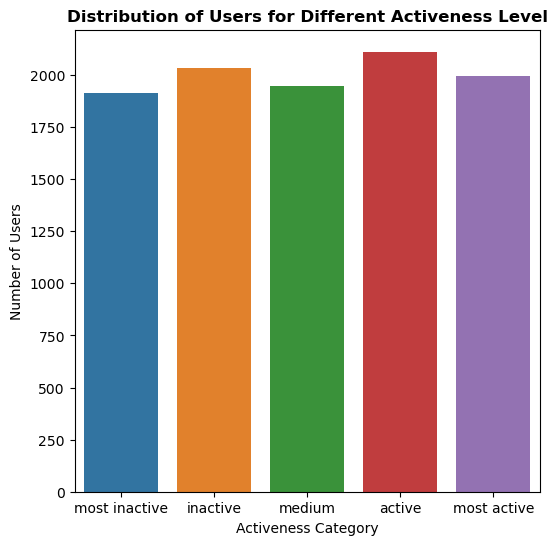

In [10]:
# try the above category, plot the percentage of frauds in each category
df['active_category'] = categories

plt.figure(figsize=(6, 6))
sns.countplot(x = 'active_category', data = df)
plt.xlabel('Activeness Category')
plt.ylabel('Number of Users')
plt.title('Distribution of Users for Different Activeness Level', fontsize = 12, fontweight = 'bold')
plt.show()

In [11]:
df['type'].value_counts()

type
user          8527
subscriber    1473
staff            4
mod              1
Name: count, dtype: int64

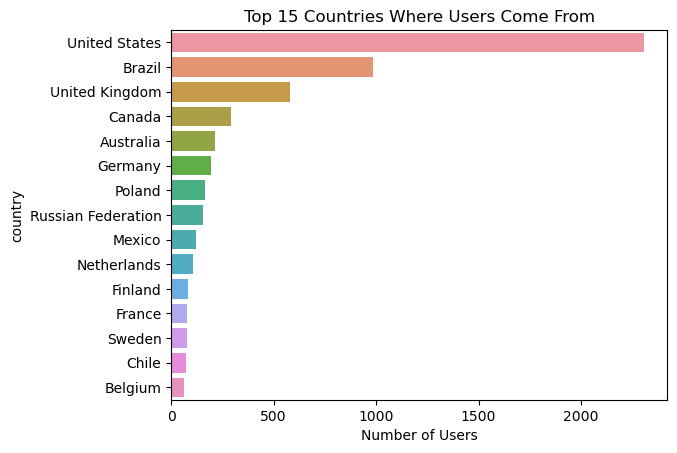

In [12]:
# Observe where users come from
nocountry = df['country'] == 'None'
df.loc[nocountry, 'country'] = 'Not Indicated'
countries = df.groupby(['country']).agg({"Username":'count'}).reset_index()
countries = countries.sort_values(by = 'Username', ascending = False).head(15)
sns.barplot(y = countries.country, x = countries.Username).set(title = 'Top 15 Countries Where Users Come From')
plt.xlabel('Number of Users')
plt.show()


We can see that except for users who did not indicate their countries, most users come from the US, Brazil, UK, Canada and Australia.

<Axes: xlabel='track_count', ylabel='registered_year'>

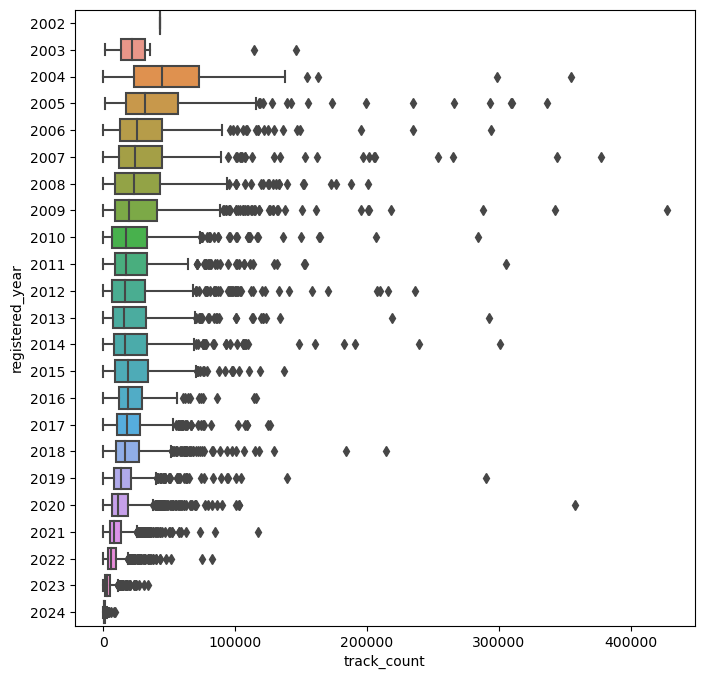

In [13]:
plt.figure(figsize=(8, 8))

df['registered_year'] = df['registered_year'].astype('category')
type(df['registered_year'][0])
sns.boxplot(y = 'registered_year', x = 'track_count', data = df)


## EDA and Feature Engineering for Songs

feature description:
The dataset contains audio features and lyrics features of songs and information (artist, title, number of listeners and playcount) we collected from Last.fm.

- listeners: number of listeners recorded on last.fm
- total_playcount: total number of playcount recorded on last.fm
- top_tags: top tags for a song, they can be user-generated on last.fm
- profanity_density: profanity level from feature engineering of the lyrics
- emotion1/2: top emotions of the song from feature engineering of the lyrics 
- Zero Crossing Rate: the rate at which the sound signal changes from positive to negative and vice versa. This feature is usually used for speech recognition and music information retrieval. Music genre with high percussive sound like rock or metal usually have high Zero Crossing Rate than other genres.
- Tempo BMP (beats per minute): Tempo is the number of beat per one minute.
- Spectral Centroid: This variable represents brightness of a sound by calculating the center of sound spectrum (where the sound signal is at its peak). We can also plot it into a wave form.
- Mel-Frequency Cepstral Coefficients: The Mel frequency Cepstral coefficients (MFCCs) of a signal are a small set of features that describes the overall shape of a spectral envelope. It imitates characteristics of human voice.
- Chroma Frequencies: Chroma feature represents the tone of music or sound by projecting its sound spectrum into a space that represents musical octave. This feature is usually used in chord recognition task.

In [2]:
songs_all = pd.read_csv('unique_songs_features_complete.csv',
                        na_filter=False  #because some track_name and artist_name are called 'null', other features do not have missing values based on previous inspection during dataset construction
).drop('lyrics', axis=1)

def safe_eval(x):
    try:
        return ast.literal_eval(x)
    except:
        return x
songs_all['toptags'] = songs_all['toptags'].apply(safe_eval)
songs_all.info()

# Converting song duration from milliseconds to minutes
songs_all['duration']=songs_all['duration_ms'].apply(lambda x : round((x/60000),2))
songs_all = songs_all.drop('duration_ms', axis=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129890 entries, 0 to 129889
Data columns (total 19 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   track_name_original   129890 non-null  object 
 1   artist_name_original  129890 non-null  object 
 2   duration_ms           129890 non-null  float64
 3   listeners             129890 non-null  float64
 4   total_playcount       129890 non-null  float64
 5   toptags               129890 non-null  object 
 6   profanity_density     129890 non-null  float64
 7   polarity              129890 non-null  float64
 8   subjectivity          129890 non-null  float64
 9   emotion1              129890 non-null  object 
 10  emotion1_score        129890 non-null  float64
 11  emotion2              129890 non-null  object 
 12  emotion2_score        129890 non-null  float64
 13  mfcc                  129890 non-null  object 
 14  chroma                129890 non-null  object 
 15  

In [3]:
# convert mfcc and chroma to array of numbers
def convert_to_float_list(s):
    # extract floating-point numbers
    # float_numbers = re.findall(r"[-+]?\d*\.\d+e[+-]?\d+|\d+", s)
    float_numbers = re.findall(r"[-+]?\d*\.\d+e[+-]?\d+|\d*\.\d+\s*|\d+\s*", s)
    # convert to list of floats
    float_list = [float(num) for num in float_numbers]
    return float_list

songs_all['mfcc'] = songs_all['mfcc'].apply(convert_to_float_list)
songs_all['chroma'] = songs_all['chroma'].apply(convert_to_float_list)
songs_all.head()

,track_name_original,artist_name_original,listeners,total_playcount,toptags,profanity_density,polarity,subjectivity,emotion1,emotion1_score,emotion2,emotion2_score,mfcc,chroma,rms,spectral_centroid,zcr,tempo,duration
0,Cradle,Mudvayne,86366.0,368525.0,"[Nu Metal, metal, math metal, alternative meta...",0.040936,-0.28963,0.66382,negative,0.111774,disgust,0.054927,"[153.13193, 125.41709, 35.41838, 41.12251, 9.5...","[0.610627, 0.52234715, 0.48563012, 0.516958, 0...",0.151819,3075.841535,0.077126,172.265625,5.23
1,Tissues,YUNGBLUD,59233.0,481214.0,"[seen live, rock]",0.000000,0.03286,0.58913,positive,0.178898,joy,0.143101,"[29.943943, 134.54782, 46.5182, 55.03315, 29.2...","[0.4032532, 0.40510523, 0.33724827, 0.41406393...",0.318193,3362.386296,0.078008,90.666118,0.00
2,The Games We Play,Pusha T,270156.0,2858530.0,"[hardcore hip hop, rap, Energetic, Gangsta Rap...",0.022523,0.08550,0.46763,positive,0.156240,joy,0.073203,"[86.60968, 117.12216, 40.658672, 45.47891, 19....","[0.2931717, 0.31128934, 0.44186398, 0.3576136,...",0.300682,3379.955173,0.072801,156.605114,2.77
3,Buffalo Replaced,Mitski,260613.0,1567117.0,"[singer-songwriter, folk rock, slowcore, indie...",0.008264,0.09979,0.58416,positive,0.121527,negative,0.050071,"[194.7339, 155.67165, 2.4118507, 61.91636, 11....","[0.53546256, 0.5702864, 0.6726932, 0.6779348, ...",0.237554,1422.434429,0.015288,135.999178,2.55
4,GODS,"League of Legends, NewJeans",10217.0,116258.0,[],0.000000,0.10330,0.43919,positive,0.134588,joy,0.063146,"[48.144855, 113.605, 31.015692, 56.467384, 24....","[0.43342552, 0.43788773, 0.47034973, 0.5488805...",0.291549,3968.761168,0.085450,72.788292,0.00


In [23]:
songs_all['mfcc_features'] = songs_all['mfcc'].apply(lambda x: np.array(x).flatten())
mfcc_features = np.stack(songs_all['mfcc_features'])
mfcc_features

array([[153.13193   , 125.41709   ,  35.41838   , ...,   1.7449448 ,
          1.242851  ,   6.411797  ],
       [ 29.943943  , 134.54782   ,  46.5182    , ...,   2.302837  ,
          6.36338   ,   0.25954217],
       [ 86.60968   , 117.12216   ,  40.658672  , ...,   1.437096  ,
          7.2659035 ,   0.38286713],
       ...,
       [ 33.553635  , 134.06999   ,  47.291656  , ...,   6.8205414 ,
          4.5975814 ,   4.9482675 ],
       [ 26.104374  , 148.44427   ,  64.71878   , ...,   1.9427578 ,
          8.228556  ,   0.51255274],
       [ 83.500824  , 148.04292   ,  36.172615  , ...,   4.295518  ,
          5.5472026 ,   4.9469123 ]])

In [4]:
# create features from mfcc and chroma
def calculate_mean_var(lst):
    if len(lst) > 0:
        audio_mean = np.mean(lst)
        audio_var = np.var(lst)
        return audio_mean, audio_var
    else:
        return np.nan, np.nan
songs_all[['mfcc_mean', 'mfcc_var']] = pd.DataFrame(songs_all['mfcc'].apply(calculate_mean_var).tolist(), index=songs_all.index)
songs_all[['chroma_mean', 'chroma_var']] = pd.DataFrame(songs_all['chroma'].apply(calculate_mean_var).tolist(), index=songs_all.index)
# feature scaling
def feature_scaling(ls):
    if len(ls) > 0:
        return sklearn.preprocessing.scale(ls)
    else:
        return ls
songs_all['mfcc_scaled'] = songs_all['mfcc'].apply(feature_scaling)
songs_all['chroma_scaled'] = songs_all['chroma'].apply(feature_scaling)
# songs_all.head()


In [34]:
# handling outliers which may interfere with the performance of ML algorithm
songs_all.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
listeners,129890.0,66770.502757,1.468033e+05,0.000000e+00,3741.000000,17497.000000,61758.750000,3.115370e+06
total_playcount,129890.0,489492.938879,1.574763e+06,0.000000e+00,16377.250000,87446.500000,357475.750000,1.476307e+08
profanity_density,129890.0,0.005056,1.438675e-02,0.000000e+00,0.000000,0.000000,0.002513,4.181818e-01
polarity,129890.0,0.042297,1.772180e-01,-1.000000e+00,-0.058175,0.040620,0.138178,1.000000e+00
subjectivity,129890.0,0.513570,1.420581e-01,0.000000e+00,0.437920,0.511280,0.593640,1.000000e+00
emotion1_score,129890.0,0.153488,7.614647e-02,2.175910e-06,0.103449,0.141375,0.188674,1.198988e+00
emotion2_score,129890.0,0.098451,4.600065e-02,7.843739e-07,0.067427,0.093311,0.123075,6.313336e-01
rms,129890.0,0.216031,8.292369e-02,0.000000e+00,0.156850,0.221249,0.274079,8.126503e-01
spectral_centroid,129890.0,2661.710082,8.322449e+02,0.000000e+00,2109.145394,2725.133924,3234.164950,1.320376e+04
zcr,129890.0,0.058133,2.437677e-02,0.000000e+00,0.040132,0.057173,0.073964,7.073940e-01


As we can see in the statistical summary, the numerical values in song features are not on the same scale, therefore we need to scale them before feeding into ML models. Next, we do logarithmic transformation for values in very large range.

In [32]:
# Logarithmic Transformation
songs_all['log_total_playcount'] = np.log1p(songs_all['total_playcount'])
songs_all['log_listeners'] = np.log1p(songs_all['listeners'])

Next we observe the distribution of relevant numerical columns

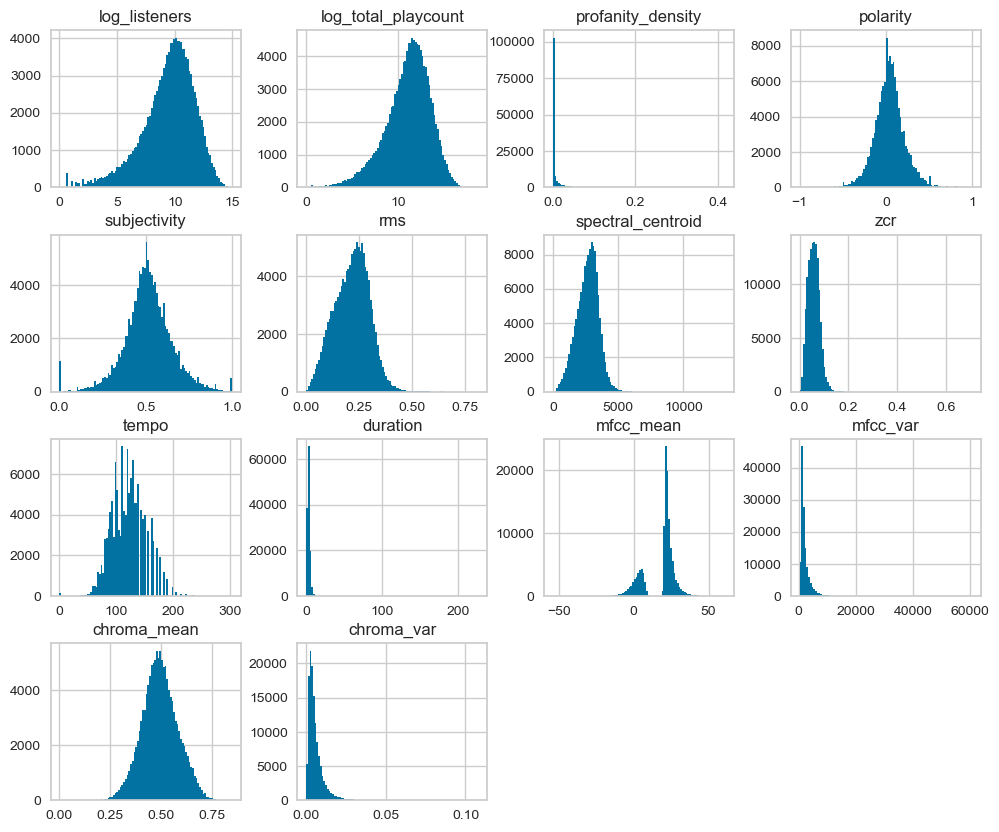

In [33]:
# observe the distribution of relevant numerical columns
numerical_features = ['log_listeners', 'log_total_playcount', 'profanity_density', 'polarity', 'subjectivity', 'rms',  'spectral_centroid', 'zcr', 'tempo', 'duration', 'mfcc_mean', 'mfcc_var', 'chroma_mean', 'chroma_var']

ax = songs_all[numerical_features].hist(figsize = (12, 10), bins = 100)

we can see the distributions of profanity_density, duration and also some audio feature columns are quite skewed.
We will deal with the outliers before feeding data into ML models. 

Next we use heatmap to observe the correlation between numerical features 

<Figure size 800x550 with 0 Axes>

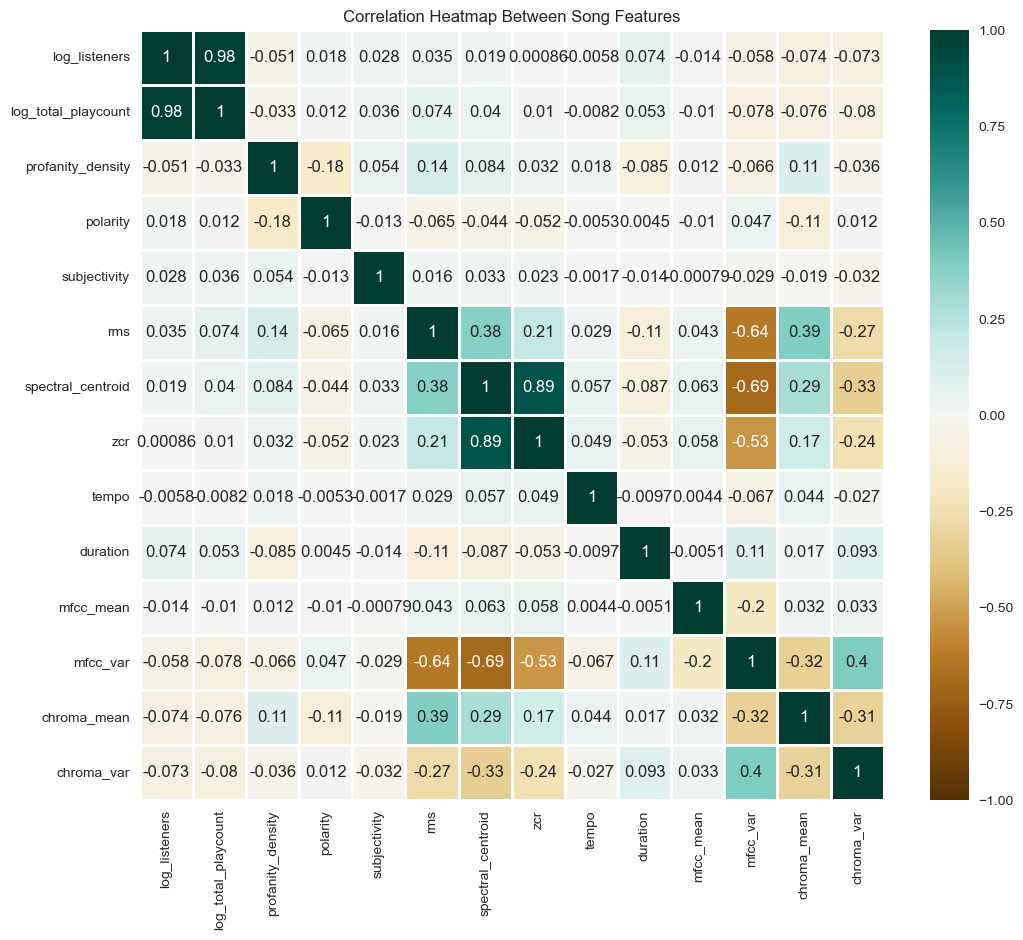

In [36]:
# heatmap to observe the correlation between numerical features 
plt.clf()
corr_df=songs_all[numerical_features].corr(method='pearson')
plt.figure(figsize=(12,10))
heatmap=sns.heatmap(corr_df, annot=True, fmt='.2g', vmin=-1, vmax=1, center=0, cmap="BrBG", linewidths=2)
heatmap.set_title('Correlation Heatmap Between Song Features')
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=90)
plt.show()

We can see from the heatmap that some features are highly correlated. Next we use scatter plot to observe their correlation.

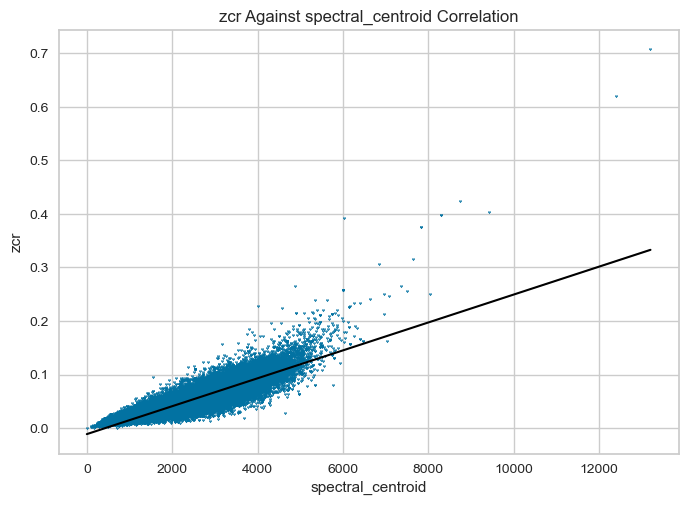

In [8]:
# observe the correlation between zcr and spectral_centroid audio features
plt.clf()
sns.regplot(data=songs_all, y='zcr', x='spectral_centroid', scatter_kws={'s':2}, marker='2', line_kws={"color": "black", 'linewidth':1.5}).set(title='zcr Against spectral_centroid Correlation')
plt.show()

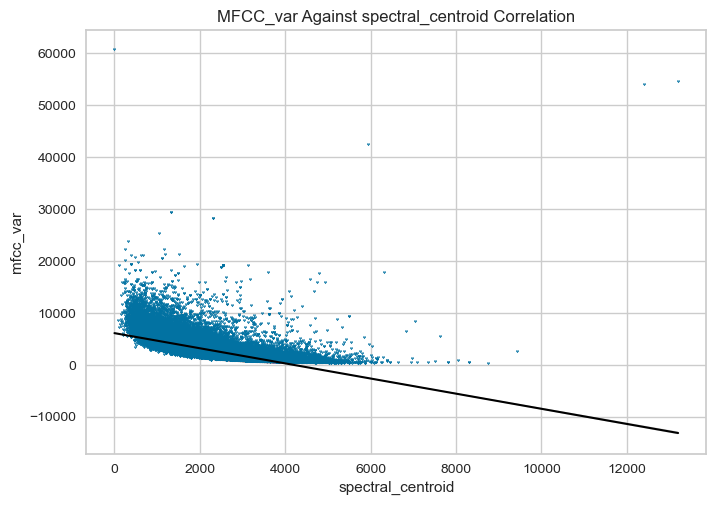

In [9]:
# observing the correlation between mfcc_var and spectral_centroid
plt.clf()
sns.regplot(data=songs_all, y='mfcc_var', x='spectral_centroid', scatter_kws={'s':2}, marker='2', line_kws={"color": "black", 'linewidth':1.5}).set(title='MFCC_var Against spectral_centroid Correlation')
plt.show()

There are 34043 unique artists. 
There are 9 unique top emotions among all the songs, we can consider use one-hot-encoding on this feature

In [41]:
print(songs_all[['artist_name_original']].nunique())
print(songs_all['emotion1'].value_counts())

artist_name_original    34043
dtype: int64
emotion1
positive    59358
negative    54054
fear         5580
trust        4890
sadness      2894
surprise     1979
anger         549
disgust       405
joy           181
Name: count, dtype: int64


We can see that most listened-to songs have emotions like joy and anger

Text(0, 0.5, 'Mood')

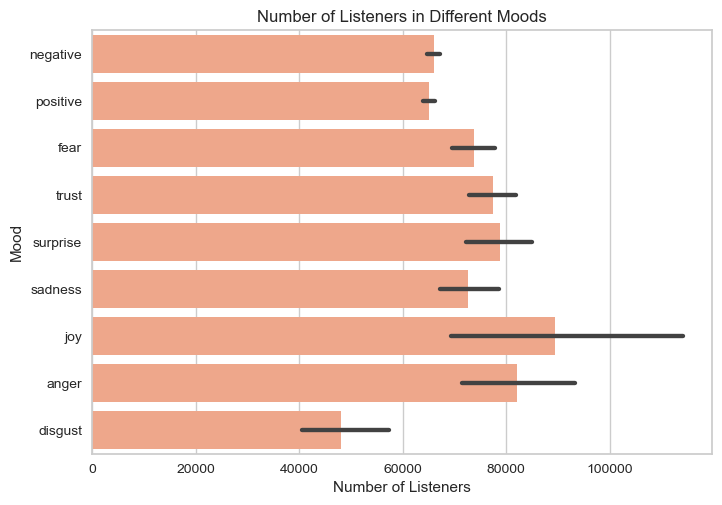

In [22]:
plt.title("Number of Listeners in Different Moods")
sns.barplot(y='emotion1', x='listeners', data=songs_all, color='lightsalmon')
plt.xlabel ("Number of Listeners")
plt.ylabel("Mood")

We can see that profanity_density is significantly higher in songs with negative, anger and disgust emotions.

Text(0, 0.5, 'Mood')

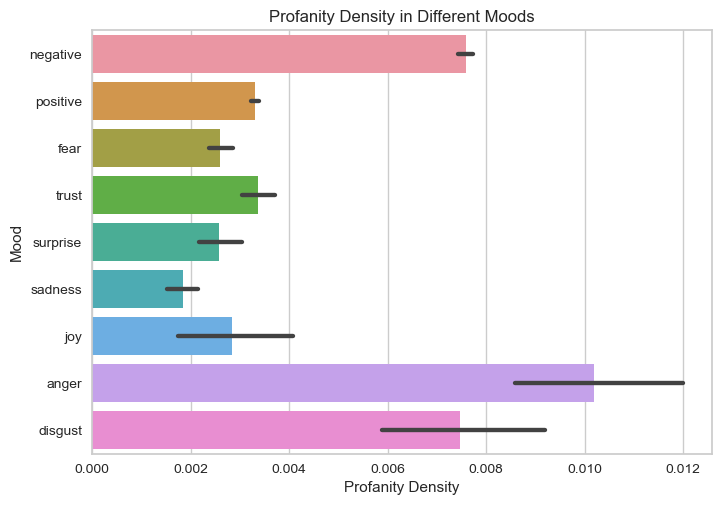

In [20]:
plt.clf()
plt.title("Profanity Density in Different Moods")
sns.barplot(y='emotion1', x='profanity_density', data=songs_all)
plt.xlabel ("Profanity Density")
plt.ylabel("Mood")

There are a large number (26180) of different tags for songs, as users are free to generate their own tags on Last.fm

It would not be so feasible to do one-hot-encoding or TFIDF on this feature

In [41]:
categories_flat = [category for sublist in songs_all['toptags'] for category in sublist]
# Count the occurrences of each category
category_counts = Counter(categories_flat)
ranked_categories = sorted(category_counts.items(), key=lambda x: x[1], reverse=True)

ranked_categories_dict = dict(ranked_categories)
len(ranked_categories_dict)

26180

### Normalization and Dimensionality Reduction

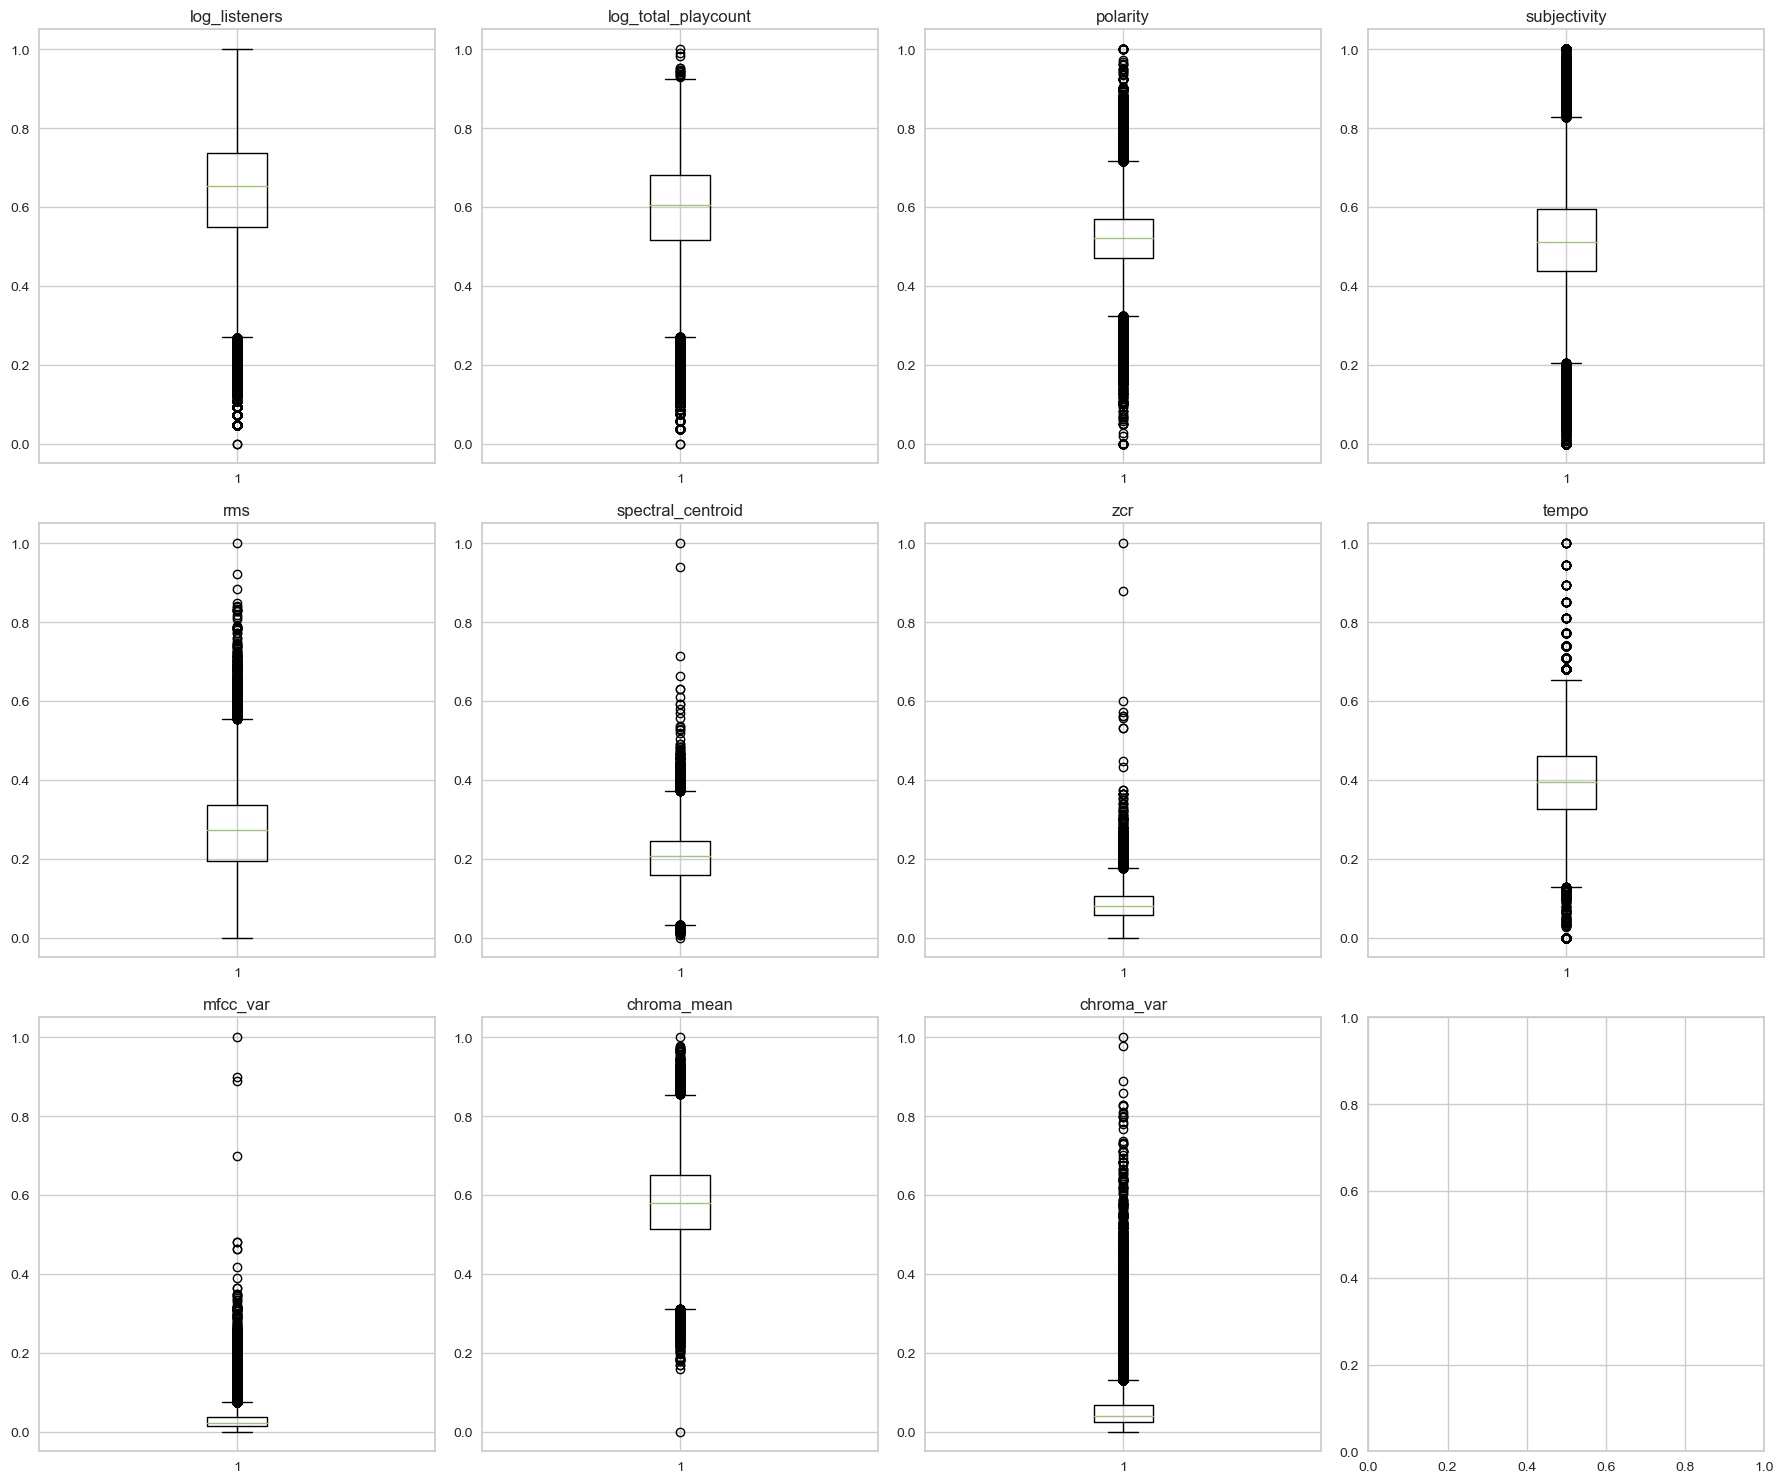

In [43]:
# numerical_features = ['listeners', 'total_playcount', 'profanity_density', 'polarity', 'subjectivity', 'rms',  'spectral_centroid', 'zcr', 'tempo', 'duration', 'mfcc_mean', 'mfcc_var', 'chroma_mean', 'chroma_var']
#  feature scaling
normalize_features = ['log_listeners', 'log_total_playcount', 'polarity', 'subjectivity', 'rms',  'spectral_centroid', 'zcr', 'tempo', 'mfcc_var', 'chroma_mean', 'chroma_var']
songs_all_normalize = songs_all[normalize_features].copy()
scaler = MinMaxScaler()

for i in songs_all[normalize_features].columns:
  songs_all_normalize[i] = scaler.fit_transform(songs_all_normalize[[i]])

# visualize the values after scaling
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(18, 15))
axs = axs.flatten()
for i, feature in enumerate(songs_all_normalize.columns):
    axs[i].boxplot(songs_all_normalize[feature])
    axs[i].set_title(feature)
plt.tight_layout()
plt.show()

In [46]:
# since profanity_density and duration have many unique values, it makes sense to convert them into categorical using bins
# low: 0 - 33%
# medium: 33 - 66%
# high: 66 - 100%
# songs_all['duration_bin'] = pd.cut(songs_all['duration'], bins=3, labels=['short', 'medium', 'long'])
# songs_all['profanity_density_bin'] = pd.cut(songs_all['profanity_density'], bins=3, labels=['low', 'medium', 'high'])

# quantile-based binning for highly skewed feature values
songs_all['duration_bin'] = pd.qcut(songs_all['duration'], q=3, labels=['short', 'medium', 'long'])
songs_all['profanity_density_bin'] = pd.qcut(songs_all['profanity_density'].rank(method='first'), q=3, labels=['low', 'medium', 'high'])

one_hot = pd.get_dummies(songs_all[['duration_bin', 'profanity_density_bin', 'emotion1']])
# feature_names = ohe.columns
# ohe.columns = ['emotion|' + str(i) for i in feature_names]
# ohe.reset_index(drop = True, inplace = True) 
# ohe.iloc[0]
one_hot.tail()
# one_hot['duration_bin_long'].value_counts()

,duration_bin_short,duration_bin_medium,duration_bin_long,profanity_density_bin_low,profanity_density_bin_medium,profanity_density_bin_high,emotion1_anger,emotion1_disgust,emotion1_fear,emotion1_joy,emotion1_negative,emotion1_positive,emotion1_sadness,emotion1_surprise,emotion1_trust
129885,False,True,False,False,False,True,False,False,False,False,False,False,False,False,True
129886,True,False,False,False,False,True,False,False,False,False,True,False,False,False,False
129887,True,False,False,False,False,True,False,False,False,False,True,False,False,False,False
129888,False,True,False,False,False,True,False,False,False,False,False,True,False,False,False
129889,True,False,False,False,False,True,False,False,False,False,True,False,False,False,False


### feature generation pipeline

In [3]:
def convert_to_float_list(s):
    # extract floating-point numbers
    # float_numbers = re.findall(r"[-+]?\d*\.\d+e[+-]?\d+|\d+", s)
    float_numbers = re.findall(r"[-+]?\d*\.\d+e[+-]?\d+|\d*\.\d+\s*|\d+\s*", s)
    # convert to list of floats
    float_list = [float(num) for num in float_numbers]
    return float_list

def calculate_mean_var(lst):
    if len(lst) > 0:
        audio_mean = np.mean(lst)
        audio_var = np.var(lst)
        return audio_mean, audio_var
    else:
        return np.nan, np.nan

def audio_feature_scaling(ls):
    if len(ls) > 0:
        return sklearn.preprocessing.scale(ls)
    else:
        return ls

def ohe_prep(df, column, new_name): 
    tf_df = pd.get_dummies(df[column])
    feature_names = tf_df.columns
    tf_df.columns = [new_name + "_" + str(i) for i in feature_names]
    tf_df.reset_index(drop = True, inplace = True)    
    return tf_df

def song_feature_eng(df, cols):
    df = df[cols]

    ## logarithmic transformation for values with large range
    df['log_total_playcount'] = np.log1p(df['total_playcount'])
    df['log_listeners'] = np.log1p(df['listeners'])
    
    ## transform audio features columns
    df['mfcc'] = df['mfcc'].apply(convert_to_float_list)
    df['chroma'] = df['chroma'].apply(convert_to_float_list)
    df[['mfcc_mean', 'mfcc_var']] = pd.DataFrame(df['mfcc'].apply(calculate_mean_var).tolist(), index=df.index)
    df[['chroma_mean', 'chroma_var']] = pd.DataFrame(df['chroma'].apply(calculate_mean_var).tolist(), index=df.index)

    # df['mfcc_scaled'] = df['mfcc'].apply(audio_feature_scaling)
    # df['mfcc_features'] = df['mfcc_scaled'].apply(lambda x: np.array(x).flatten())
    # mfcc_features = np.stack(df['mfcc_features'])
    # df['chroma_scaled'] = df['chroma'].apply(audio_feature_scaling)

    ## normalize features
    normalize_features = ['log_listeners', 'log_total_playcount', 'polarity', 'subjectivity', 'rms',  'spectral_centroid', 'zcr', 'tempo', 'mfcc_var', 'chroma_mean', 'chroma_var']
    songs_all_normalize = df[normalize_features].reset_index(drop = True)
    scaler = MinMaxScaler()
    floats_scaled = pd.DataFrame(scaler.fit_transform(songs_all_normalize), columns = songs_all_normalize.columns) * 0.2

    ## one-hot encoding features
    df['duration_bin'] = pd.qcut(df['duration'], q=3, labels=['short', 'medium', 'long'])
    df['profanity_density_bin'] = pd.qcut(df['profanity_density'].rank(method='first'), q=3, labels=['low', 'medium', 'high'])

    profanity_ohe = ohe_prep(df, 'profanity_density_bin', 'profanity') * 0.3
    duration_ohe = ohe_prep(df, 'duration_bin', 'duration') * 0.3
    emotion_ohe = ohe_prep(df, 'emotion1', 'emotion') * 0.1

    eng_df = pd.concat([floats_scaled, profanity_ohe, duration_ohe, emotion_ohe], axis = 1)
    # eng_df = pd.concat([mfcc_features, floats_scaled, profanity_ohe, duration_ohe, emotion_ohe], axis = 1)
    eng_df['track_name'] = df['track_name_original'].values
    eng_df['artist_name'] = df['artist_name_original'].values
    
    return eng_df

In [5]:
songs_all_eng = song_feature_eng(songs_all, songs_all.columns.tolist())
songs_all_eng

,log_listeners,log_total_playcount,polarity,subjectivity,rms,spectral_centroid,zcr,tempo,mfcc_var,chroma_mean,chroma_var,profanity_low,profanity_medium,profanity_high,duration_short,duration_medium,duration_long,emotion_anger,emotion_disgust,emotion_fear,emotion_joy,emotion_negative,emotion_positive,emotion_sadness,emotion_surprise,emotion_trust,track_name,artist_name
0,0.152039,0.136280,0.071037,0.132764,0.037364,0.046590,0.021806,0.113333,0.004632,0.122652,0.014591,0.0,0.0,0.3,0.0,0.0,0.3,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,Cradle,Mudvayne
1,0.146995,0.139117,0.103286,0.117826,0.078310,0.050931,0.022055,0.059649,0.002055,0.104831,0.009134,0.3,0.0,0.0,0.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,Tissues,YUNGBLUD
2,0.167294,0.158061,0.108550,0.093526,0.074000,0.051197,0.020583,0.103030,0.002134,0.096632,0.009453,0.0,0.0,0.3,0.0,0.3,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,The Games We Play,Pusha T
3,0.166813,0.151670,0.109979,0.116832,0.058464,0.021546,0.004322,0.089474,0.007976,0.133884,0.008515,0.0,0.0,0.3,0.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,Buffalo Replaced,Mitski
4,0.123488,0.124013,0.110330,0.087838,0.071753,0.060116,0.024159,0.047887,0.001392,0.114345,0.010769,0.3,0.0,0.0,0.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,GODS,"League of Legends, NewJeans"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129885,0.129046,0.122504,0.093492,0.099682,0.054113,0.035945,0.014330,0.085000,0.003984,0.076720,0.010784,0.0,0.0,0.3,0.0,0.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,Drug Dealer,Anthony Green
129886,0.058104,0.065464,0.102654,0.107730,0.057287,0.037047,0.014517,0.087179,0.005489,0.111696,0.009449,0.0,0.0,0.3,0.3,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,Pink Sky (Can I Tell You Something?),Be Good
129887,0.128933,0.126094,0.140741,0.102408,0.071469,0.050733,0.021471,0.050746,0.002079,0.119976,0.004049,0.0,0.0,0.3,0.3,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,Sink With You,Underoath
129888,0.140622,0.131505,0.101111,0.088240,0.082395,0.044400,0.019960,0.062963,0.002890,0.130993,0.010008,0.0,0.0,0.3,0.0,0.3,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,Endseekers,"Oh, Sleeper"


### PCA

Explained variance ratio of each component: [2.55927360e-01 2.30783133e-01 2.29360108e-01 2.04831585e-01
 3.37529135e-02 1.16190103e-02 6.56670879e-03 6.04177358e-03
 4.98617672e-03 3.07641046e-03 2.77483528e-03 2.16564222e-03
 1.98326633e-03 1.90884466e-03 1.30036563e-03 1.27250393e-03
 6.47235628e-04 3.86834466e-04 2.60342146e-04 1.17642247e-04
 1.02546489e-04 8.72578343e-05 4.75033456e-05 4.95994913e-31
 1.70015475e-31 4.03742487e-33]


<Figure size 800x550 with 0 Axes>

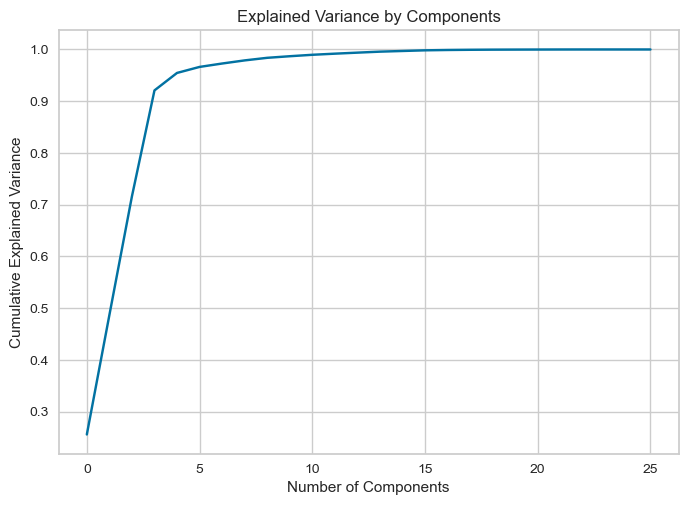

In [9]:
## PCA with feature engineering
numerical_features = ['log_listeners', 'log_total_playcount', 'polarity', 'subjectivity',
                        'rms', 'spectral_centroid', 'zcr', 'tempo', 'mfcc_var', 'chroma_mean',
                        'chroma_var', 'profanity_low', 'profanity_medium', 'profanity_high',
                        'duration_short', 'duration_medium', 'duration_long', 'emotion_anger',
                        'emotion_disgust', 'emotion_fear', 'emotion_joy', 'emotion_negative',
                        'emotion_positive', 'emotion_sadness', 'emotion_surprise',
                        'emotion_trust']
X = songs_all_eng[numerical_features]
pca = PCA()
X_pca = pca.fit_transform(X)

print("Explained variance ratio of each component:", pca.explained_variance_ratio_)
plt.clf()
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Components')
plt.grid(True)
plt.show()

# The results show that the first principal component explains 25.59% of the total variance in data.
# Combining the first four principal components, they can explain about 92.09% of total variance in the data.

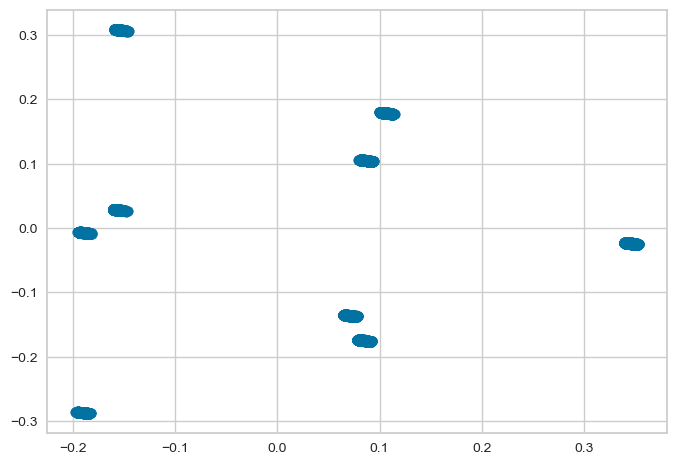

In [19]:
plt.scatter([i[0] for i in X_pca], [i[1] for i in X_pca])

In [28]:
## saving a version of dataset with principal components
X = songs_all_eng[numerical_features]

pca = PCA(n_components=4)
X_pca = pca.fit_transform(X)
pc_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2', 'PC3', 'PC4'])
result_df = pd.concat([X, pc_df], axis=1)
result_df['track_name'] = songs_all_eng['track_name'].values
result_df['artist_name'] = songs_all_eng['artist_name'].values
result_df.to_csv('songs_feature_eng_pca.csv', index=False)

import joblib
joblib.dump(pca, 'pca_model.pkl')


['pca_model.pkl']

Explained variance ratio of each component: [0.35851202 0.20611955 0.16041523 0.13789469 0.07040465 0.0406023
 0.01982378 0.00305992 0.0024521  0.00071577]


<Figure size 800x550 with 0 Axes>

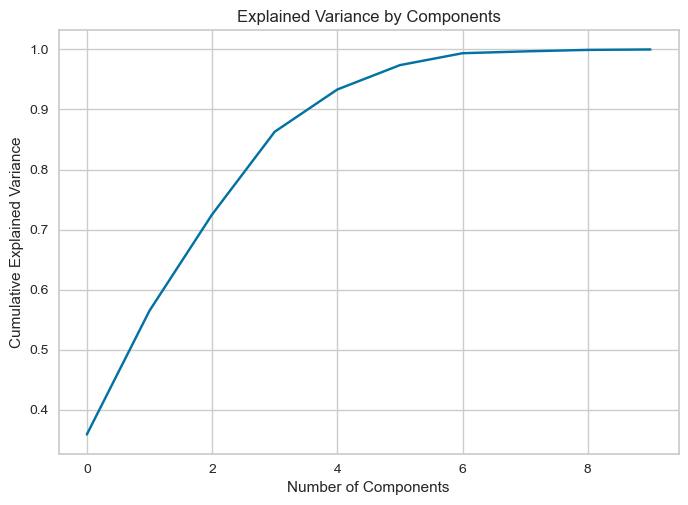

In [22]:
## PCA without feature engineering
numerical_features = ['listeners', 'total_playcount', 'profanity_density', 'polarity', 'subjectivity', 'tempo', 'duration', 'spectral_centroid', 'rms', 'zcr']
X = songs_all[numerical_features]
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA()
X_pca = pca.fit_transform(X_scaled)

print("Explained variance ratio of each component:", pca.explained_variance_ratio_)
plt.clf()
plt.figure()
# View the explained variance ratio for each principal component
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Components')
plt.grid(True)
plt.show()

# the results show that the first principal component explains 35.85% of the total variance in data
# combining the first five principal components, they can explain about 93.33% of total variance in the data.

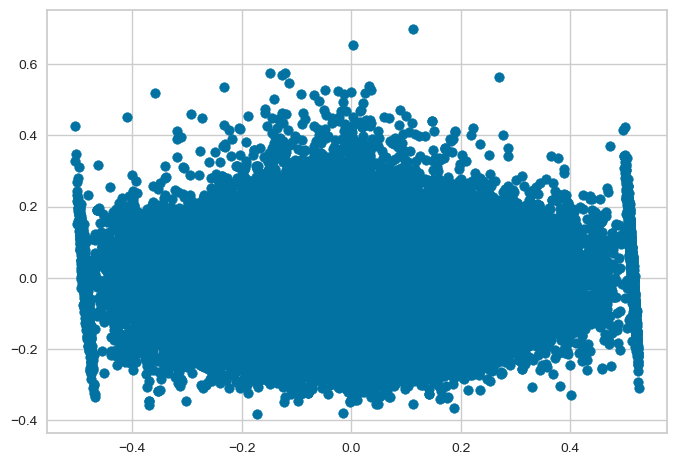

In [70]:
plt.scatter([i[0] for i in X_pca], [i[1] for i in X_pca])

### Clustering Songs with K-Means

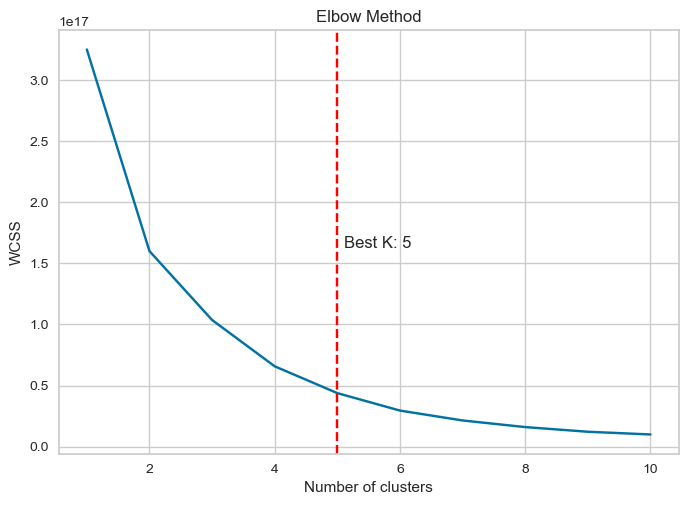

In [27]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

# plot the elbow curve
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

# show the best k value
best_k = 5
plt.axvline(x=best_k, linestyle='--', color='red')
plt.text(best_k + 0.1, max(wcss)/2, f'Best K: {best_k}')

plt.show()

In [28]:
n_clusters = min(5, X_pca.shape[0])
kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
kmeans.fit(X_pca)
cluster_labels = kmeans.predict(X_pca)
centroids = kmeans.cluster_centers_
print(centroids)
# # Get the features used in clustering
# features = ['valence', 'energy', 'instrumentalness', 'key', 'liveness', 'speechiness', 'decade']
# cluster_features = [f for f in features if f in data.columns]


[[ 2.34888171e-01  1.39138409e-02 -4.20424741e-03  1.79553419e-02
   3.84522666e-03  2.81974068e-03 -4.66343373e-03 -1.50587221e-04
  -3.66674198e-04 -1.48699248e-04]
 [ 2.92597204e-03  1.48213937e-02  1.20563681e-01 -6.49647664e-03
   1.56669834e-04 -4.99241355e-04  1.11409613e-03  5.31627749e-04
  -2.15110084e-05  1.92626652e-05]
 [ 7.66428435e-03 -1.24569140e-01 -2.84010454e-02 -2.42816822e-03
  -3.13502116e-03 -1.83761392e-03  2.14430261e-03 -9.99893494e-05
   1.62071518e-04  1.81702587e-05]
 [-2.10174039e-01  1.00060803e-02 -6.67447329e-03  3.46064822e-02
   2.44777825e-03  1.81576767e-03 -4.07589895e-03  4.04786187e-05
  -3.50887238e-04 -1.01158685e-04]
 [ 2.85500228e-03  7.99322032e-02 -5.18845074e-02 -2.03151240e-02
  -5.65430089e-04 -3.91414886e-04  1.76447796e-03 -2.29378164e-04
   2.33340188e-04  9.23399894e-05]]


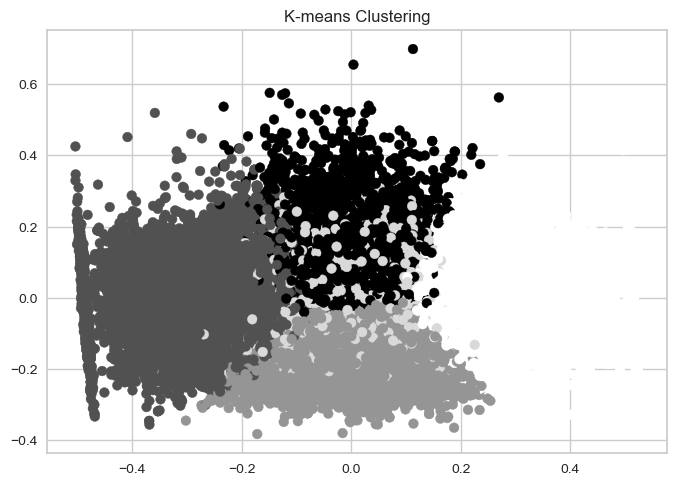

In [29]:
# Plot the clusters
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels)
plt.title("K-means Clustering")
plt.show()

In [ ]:
# song_cluster_pipeline = Pipeline([('scaler', StandardScaler()), ('kmeans', KMeans(n_clusters=20, verbose=False))], verbose=False)

# X = songs_all[numerical_features].select_dtypes(np.number)
# song_cluster_pipeline.fit(X)
# song_cluster_labels = song_cluster_pipeline.predict(X)
# songs_all['cluster_label'] = song_cluster_labels

In [21]:
# numerical_features = ['listeners', 'total_playcount', 'profanity_density', 'polarity', 'subjectivity', 'tempo', 'duration', 'spectral_centroid', 'rms', 'zcr']
# X = songs_all[numerical_features]
# scaler = MinMaxScaler()
# X_scaled = scaler.fit_transform(X)

# Instantiate the t-SNE object
n_components = 2
perplexity = 10
tsne = TSNE(n_components=n_components, perplexity=perplexity, 
            # learning_rate=200, n_iter=1000, 
            random_state=42)
X_tsne = tsne.fit_transform(X)
plt.clf()
plt.figure(figsize=(10, 8))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], alpha=0.5)
plt.title('t-SNE visualization of the dataset')
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.show()

KeyboardInterrupt: 